In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [33]:
def plot_potential(ax, potential_scalar_field, min_grid=-4, max_grid=4, level_min=-1, level_max=4, num_levels=12):
    # Generate coordinates for plotting
    x = np.linspace(min_grid, max_grid, 100)
    y = np.linspace(min_grid, max_grid, 100)
    X, Y = np.meshgrid(x, y)

    # Calculate potential energy values
    Z = potential_scalar_field(X, Y)

    # Define discrete levels for contour plot
    levels = np.linspace(level_min, level_max, num_levels)

    # Plotting the contour plot with reversed colors on a blue-red scale
    cmap = plt.cm.RdBu_r
    norm = plt.Normalize(vmin=level_min, vmax=level_max)
    cmap.set_over(color='white')  

    ax.contourf(X, Y, Z, levels=levels, cmap=cmap, norm=norm, extend='both')
    ax.colorbar(label='Potential Energy')
    ax.set_title('Potential')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')


def plot_potential_and_diffusion2(i, ax, potential_scalar_field, diffusion_matrix_field, 
                                 min_grid=-4, max_grid=4, level_min=-1, level_max=4, 
                                 num_levels=12, diff_min=-4, diff_max=4, 
                                 diff_scale=15, diff_levels=10):
    """
    Plots a potential energy scalar field as a contour map and overlays it with
    the eigenvectors of a diffusion matrix field.

    The eigenvectors are plotted as arrows, scaled by their corresponding eigenvalues,
    to represent the direction and magnitude of diffusion.

    Args:
        potential_scalar_field (callable): A function that takes X, Y coordinates and 
                                           returns potential energy values.
        diffusion_matrix_field (callable): A function that takes x, y coordinates and 
                                           returns a 2x2 diffusion matrix (np.ndarray).
        min_grid (float): The minimum coordinate value for the main plot grid.
        max_grid (float): The maximum coordinate value for the main plot grid.
        level_min (float): The minimum potential energy level for the contour plot.
        level_max (float): The maximum potential energy level for the contour plot.
        num_levels (int): The number of contour levels.
        diff_min (float): The minimum coordinate for the diffusion vector grid.
        diff_max (float): The maximum coordinate for the diffusion vector grid.
        diff_scale (float): The scaling factor for the quiver arrows. Larger values 
                            make arrows smaller.
        diff_levels (int): The number of points along each axis for the diffusion grid.
    """
    # Generate coordinates for the high-resolution contour plot
    x_hr = np.linspace(min_grid, max_grid, 100)
    y_hr = np.linspace(min_grid, max_grid, 100)
    X_hr, Y_hr = np.meshgrid(x_hr, y_hr)

    # Calculate potential energy values
    Z = potential_scalar_field(X_hr, Y_hr)

    # Define discrete levels for contour plot
    levels = np.linspace(level_min, level_max, num_levels)

    # Plotting the contour plot with reversed colors on a blue-red scale
    cmap = plt.cm.RdBu_r
    norm = plt.Normalize(vmin=level_min, vmax=level_max)
    cmap.set_over(color='white')  

    # fig, ax = plt.subplots(figsize=(8, 6))

    contour = ax.contourf(X_hr, Y_hr, Z, levels=levels, cmap=cmap, norm=norm, extend='both')
    
    # Example colorbar code (uncomment if needed)
    # cbar = plt.colorbar(contour, label='Potential Energy', ax=ax)
    # cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # cbar.ax.tick_params(labelsize=17)
    # cbar.ax.yaxis.label.set_size(19)

    ax.set_xlabel('x₁', fontsize=18)
    ax.set_ylabel('x₂', fontsize=18)
    ax.set_aspect('equal', adjustable='box') # Keep aspect ratio for correct vector angles

    # --- START OF MODIFIED SECTION ---

    # Subsample the grid for plotting the eigenvectors
    x_sub = np.linspace(diff_min, diff_max, diff_levels)
    y_sub = np.linspace(diff_min, diff_max, diff_levels)
    X_sub, Y_sub = np.meshgrid(x_sub, y_sub)

    # Initialize arrays for eigenvector components
    U1, V1 = np.zeros_like(X_sub), np.zeros_like(Y_sub) # Components for 1st eigenvector
    U2, V2 = np.zeros_like(X_sub), np.zeros_like(Y_sub) # Components for 2nd eigenvector

    # Calculate eigenvectors and scale by eigenvalues at each grid point
    for i in range(len(x_sub)):
        for j in range(len(y_sub)):
            # Get the diffusion matrix at the point (x, y)
            D_matrix = diffusion_matrix_field(x_sub[i], y_sub[j])
            
            # Calculate eigenvalues and eigenvectors.
            # np.linalg.eigh is used for symmetric matrices and returns sorted eigenvalues.
            eigenvalues, eigenvectors = np.linalg.eigh(D_matrix)
            
            # First eigenvalue and corresponding eigenvector
            lambda1 = eigenvalues[0]
            v1 = eigenvectors[:, 0]

            # Second eigenvalue and corresponding eigenvector
            lambda2 = eigenvalues[1]
            v2 = eigenvectors[:, 1]
            
            # Scale eigenvectors by their eigenvalues and store components.
            # Note the indexing: meshgrid('ij') would be U[i, j], but default is ('xy') so U[j, i]
            U1[j, i] = lambda1 * v1[0]
            V1[j, i] = lambda1 * v1[1]
            U2[j, i] = lambda2 * v2[0]
            V2[j, i] = lambda2 * v2[1]

    # Plot the scaled eigenvectors using quiver
    # Plotting both positive and negative directions to show the full axis
    ax.quiver(X_sub, Y_sub, U1, V1, color='blue', scale=diff_scale, label='Eigenvector 1 ($\lambda_1 v_1$)')
    ax.quiver(X_sub, Y_sub, -U1, -V1, color='blue', scale=diff_scale)
    
    ax.quiver(X_sub, Y_sub, U2, V2, color='red', scale=diff_scale, label='Eigenvector 2 ($\lambda_2 v_2$)')
    ax.quiver(X_sub, Y_sub, -U2, -V2, color='red', scale=diff_scale)
    
    # --- END OF MODIFIED SECTION ---
    
    ax.set_xlabel('x₁', fontsize=18)
    ax.set_ylabel('x₂', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.legend()
    # save a pdf
    # plt.tight_layout()
    # plt.savefig('potential_with_diffusion2.pdf')
    # plt.show()

def plot_potential_and_diffusion(potential_scalar_field, diffusion_matrix_field, min_grid=-4, max_grid=4, level_min=-1, level_max=4, num_levels=12, diff_min=-4, diff_max=4, diff_scale=15, diff_levels=10):
    # Generate coordinates for plotting
    x = np.linspace(min_grid, max_grid, 100)
    y = np.linspace(min_grid, max_grid, 100)
    X, Y = np.meshgrid(x, y)

    # Calculate potential energy values
    Z = potential_scalar_field(X, Y)

    # Define discrete levels for contour plot
    levels = np.linspace(level_min, level_max, num_levels)

    # Plotting the contour plot with reversed colors on a blue-red scale
    cmap = plt.cm.RdBu_r
    norm = plt.Normalize(vmin=-1, vmax=4)
    cmap.set_over(color='white')  

    fig, ax = plt.subplots(figsize=(8, 6))

    contour = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, norm=norm, extend='both')
    # if i == 3:
    #     cbar = plt.colorbar(contour, label='Potential Energy', ax=ax)
    #     # Set color bar tick format to 2 decimal places
    #     cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #     # Increase the font size of the color bar label and ticks
    #     cbar.ax.tick_params(labelsize=17)  # Ticks size
    #     cbar.ax.yaxis.label.set_size(19)   # Label font size
    #ax.set_title('Potential Energy Landscape')
    # set an x label as x1 where the 1 is a subscript
    ax.set_xlabel('x₁', fontsize=18)
    # set a y label as y1 where the 1 is a subscript
    ax.set_ylabel('x₂', fontsize=18)

    # Subsample the grid for plotting the eigenvectors
    x = np.linspace(diff_min, diff_max, diff_levels)
    y = np.linspace(diff_min, diff_max, diff_levels)
    X, Y = np.meshgrid(x, y)

    dx = np.zeros((len(x), len(y)))
    dy = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            dx[i, j] = np.sqrt((diffusion_matrix_field(x[i], y[j])[0, 0])**2 + (diffusion_matrix_field(x[i], y[j])[0, 1])**2)
            dy[i, j] = np.sqrt((diffusion_matrix_field(x[i], y[j])[1, 0])**2 + (diffusion_matrix_field(x[i], y[j])[1, 1])**2)

    ax.quiver(Y, X, dx, 0, scale=diff_scale, color='b', label='Eigenvalue 1')
    ax.quiver(Y, X, 0, dy, scale=diff_scale, color='r', label='Eigenvalue 2')
    ax.quiver(Y, X, - dx, 0, scale=diff_scale, color='b')
    ax.quiver(Y, X, 0, -dy, scale=diff_scale, color='r')

    ax.set_xlabel('X', fontsize=18)
    ax.set_ylabel('Y', fontsize=18)
    # set the fontsize of the x and y axis ticks
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    # set the fontsize of the colorbar ticks
    # if i == 3:
    #     cbar.ax.tick_params(labelsize=17)
    #     # set the fontsize of the colourbar label   
    #     cbar.ax.yaxis.label.set_size(17)

def plot_potential_with_set_of_diffusions(
    titles, 
    potential_scalar_field, 
    list_of_diffusion_matrix_fields, 
    min_grid=-4, 
    max_grid=4, 
    level_min=-1, 
    level_max=4, 
    num_levels=12, 
    diff_min=-4, 
    diff_max=4, 
    diff_scale=None, 
    diff_levels=10
):
    # Create a 2x2 grid for subplots
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    ax = ax.flatten()  # Flatten to easily index
    
    for i, (diffusion_matrix_field, diff_scl) in enumerate(zip(list_of_diffusion_matrix_fields, diff_scale)):
        plot_potential_and_diffusion2(
            i, 
            ax[i], 
            potential_scalar_field, 
            diffusion_matrix_field, 
            min_grid, 
            max_grid, 
            level_min, 
            level_max, 
            num_levels, 
            diff_min, 
            diff_max, 
            diff_scl, 
            diff_levels
        )
        ax[i].set_title(titles[i], fontsize=20)
        
    plt.tight_layout()
    plt.savefig('potential_with_diffusion.pdf')
    plt.show()


# def plot_potential_with_set_of_diffusions(titles, potential_scalar_field, list_of_diffusion_matrix_fields, min_grid=-4, max_grid=4, level_min=-1, level_max=4, num_levels=12, diff_min=-4, diff_max=4, diff_scale=15, diff_levels=10):
#     fig, ax = plt.subplots(1, len(list_of_diffusion_matrix_fields), figsize=(20, 5), gridspec_kw={'width_ratios': [1] * (len(list_of_diffusion_matrix_fields) - 1) + [1.25]})

#     for i, diffusion_matrix_field in enumerate(list_of_diffusion_matrix_fields):
#         plot_potential_and_diffusion(i, ax[i], potential_scalar_field, diffusion_matrix_field, min_grid, max_grid, level_min, level_max, num_levels, diff_min, diff_max, diff_scale, diff_levels)
#         #ax[i].set_title('Potential Energy Landscape with Diffusion')
#         ax[i].set_title(titles[i], fontsize=19)
        
#     plt.tight_layout()
#     plt.savefig('potential_with_diffusion.pdf')
#     plt.show()


def plot_experiments(exp_name, min_log10_stepsize=-2, base_dir="./simulation_results/", offset1=1, offset2=1, time_rescaling_factor=None, tr_trim=None, plot_dir="./plots"):
    exp_dir = os.path.join(base_dir, exp_name)
    data_files = glob.glob(os.path.join(exp_dir, "*.csv"))

    for data_file in data_files:
        integrator_name = os.path.splitext(os.path.basename(data_file))[0]
        convergence_data = np.array(np.genfromtxt(data_file, delimiter=','))
        number_of_steps, number_of_repeats = convergence_data.shape
        mean_convergence = np.mean(convergence_data, axis=1)
        std_convergence = np.std(convergence_data, axis=1)

        stepsizes = np.logspace(min_log10_stepsize, min_log10_stepsize + 0.1 * (number_of_steps-1), number_of_steps)
        if time_rescaling_factor is not None and integrator_name == "leimkuhler_matthews1D_time_rescaling":
            print("Assuming that the Leimkuhler-Matthews integrator is time rescaled, with factor: ", time_rescaling_factor)
            stepsizes = stepsizes * time_rescaling_factor
            if tr_trim is not None:
                stepsizes = stepsizes[tr_trim:]
                mean_convergence = mean_convergence[tr_trim:]
                std_convergence = std_convergence[tr_trim:]
        
        # plot the mean convergence
        plt.plot(stepsizes, mean_convergence, label=integrator_name)
        plt.fill_between(stepsizes, mean_convergence - std_convergence,
                        mean_convergence + std_convergence, alpha=0.3)
        
    stepsizes_for_guide_lines = np.logspace(min_log10_stepsize, min_log10_stepsize + 0.1 * (10-1), 10)
        
    legend = plt.legend()
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 0.01))
    plt.ylabel("Mean L1 Error, invariant measure")
    plt.plot(stepsizes_for_guide_lines, offset1 * np.array(stepsizes_for_guide_lines), label="Gradient 1", color="black", linestyle="--", alpha=0.5)
    plt.plot(stepsizes_for_guide_lines, offset2 * np.array(stepsizes_for_guide_lines)**2, label="Gradient 2", color="black", linestyle="--", alpha=0.5)
    plt.xlabel("Stepsize, h")
    plt.yscale('log')
    plt.xscale('log')
    fig = plt.gcf()
    fig.set_size_inches(10, 7)

### 1. Quadruple Well Potential 2D

#### 1.1 Potential

$$ 
V(x, y) = \sqrt{\frac{17}{16} - 2x^2 + x^4} + \sqrt{\frac{17}{16} - 2y^2 + y^4}
$$

In [27]:
def quadruple_well_potential(x, y):
    return np.sqrt(17/16 - 2*x**2 + x**4) + np.sqrt(17/16 - 2*y**2 + y**4)

In [13]:
plot_potential(quadruple_well_potential, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30)

TypeError: plot_potential() missing 1 required positional argument: 'potential_scalar_field'

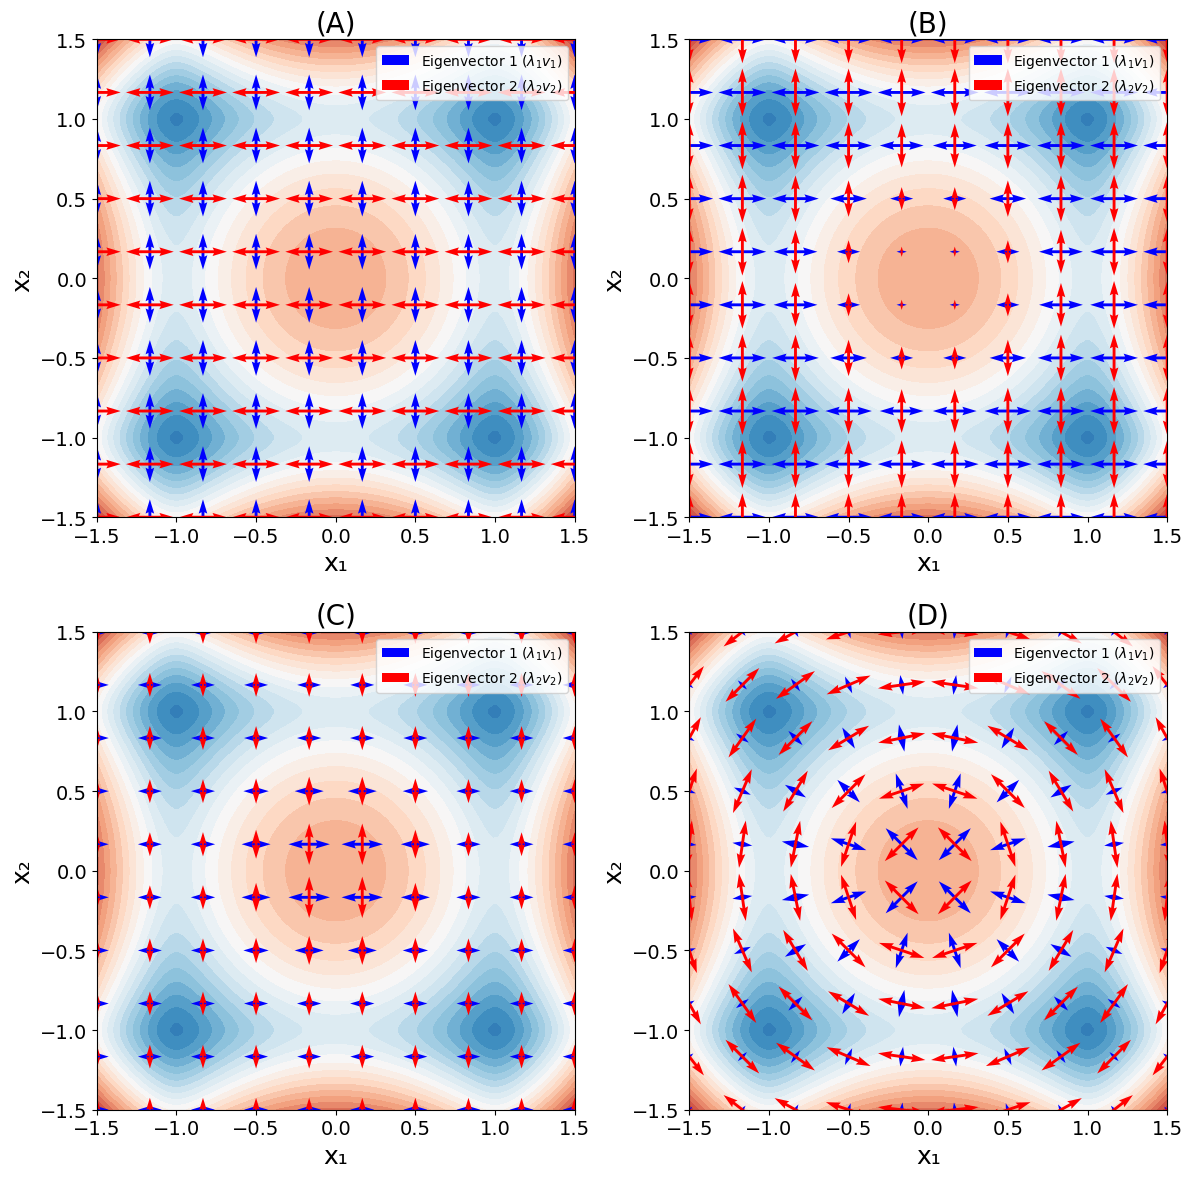

In [34]:
diffusion_tensors = [basic_anisotropic_diffusion_field, isotropic_MoroCardin_diffusion_field, inverse_isotropic_MoroCardin_diffusion_field, anisotropic_diffusion_field]
titles = ["(A)", "(B)", "(C)", "(D)"]
plot_potential_with_set_of_diffusions(titles, quadruple_well_potential, diffusion_tensors, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=[40, 20, 40, 20], diff_levels=10)

#### 1.2 Isotropic (Moro-Cardin Diffusion)

$$
D(x, y) = \frac{1}{1 + 5e^{- \frac{x^2 + y^2}{0.18}}} \mathbf{1}_{2 \times 2}
$$

In [28]:
def isotropic_MoroCardin_diffusion_field(x, y):
    return 1/(1.0 + 5.0 * np.exp(- (x**2 + y**2) / (2 * 0.3**2))) * np.array([[1, 0], [0, 1]])

def inverse_isotropic_MoroCardin_diffusion_field(x, y):
    return (1.0 + 1.0 * np.exp(- (x**2 + y**2) / (2 * 0.3**2))) * np.array([[1, 0], [0, 1]])

In [6]:
def ring_potential(x, y):
    return 25 * (1 - np.sqrt(x**2 + y**2))**2

def axial_diffusion_field(x0, x1):
    x = np.array([x0, x1])
    norm_sq = np.dot(x, x)
    if norm_sq == 0:
        return np.eye(2)  # Handle x = 0 case
    outer_xx = np.outer(x, x)
    Sigma = np.eye(2) - 0.5 * outer_xx / norm_sq
    return Sigma

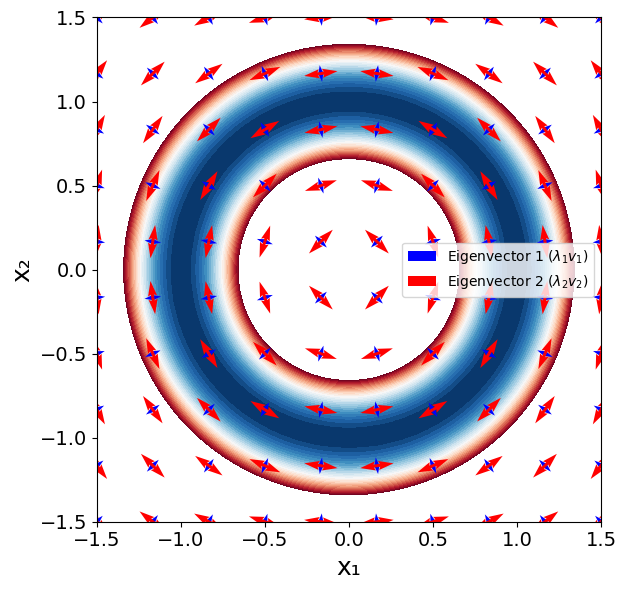

In [25]:
plot_potential_and_diffusion2(ring_potential, axial_diffusion_field, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=30)

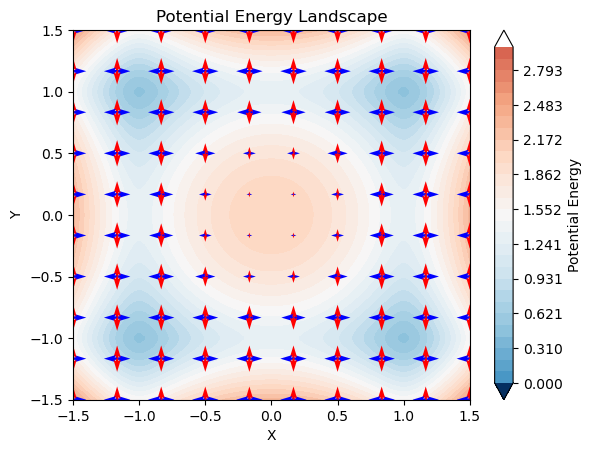

In [38]:
plot_potential_and_diffusion(quadruple_well_potential, isotropic_MoroCardin_diffusion_field, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=30)

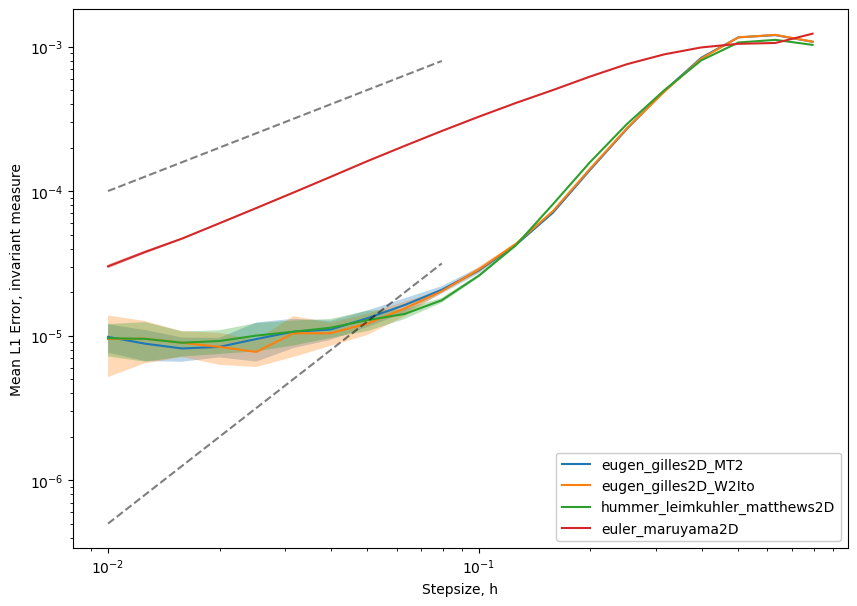

In [10]:
plot_experiments("qw_morocardin_2D_500K", min_log10_stepsize=-2, base_dir="./simulation_results/", offset1=0.01, offset2=0.005, time_rescaling_factor=None, tr_trim=None, plot_dir="./plots")

### 1.3 Anisotropic I

$$
D(x, y) = \begin{bmatrix}
1 & 0 \\
0 & 1.5
\end{bmatrix}
$$

In [29]:
def basic_anisotropic_diffusion_field(x, y):
    return np.array([[2, 0], [0, 1.5]])

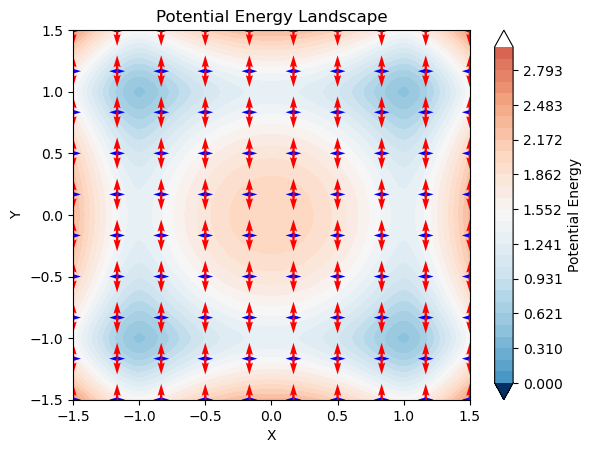

In [67]:
plot_potential_and_diffusion(quadruple_well_potential, basic_anisotropic_diffusion_field, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=50)

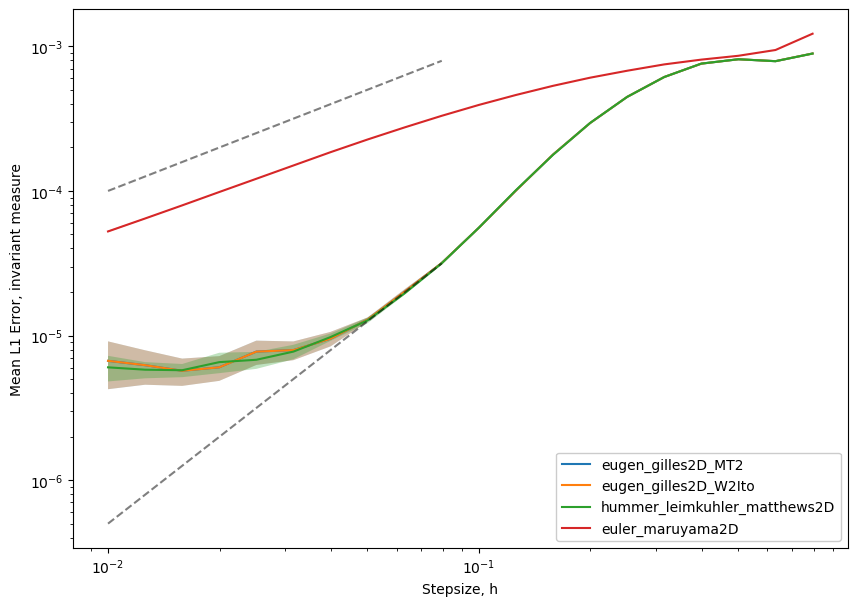

In [11]:
plot_experiments("qw_anisotropicI_500K", min_log10_stepsize=-2, base_dir="./simulation_results/", offset1=0.01, offset2=0.005, time_rescaling_factor=None, tr_trim=None, plot_dir="./plots")

#### 1.3 Anisotropic II

$$
D(r, \theta) = \begin{bmatrix}
1 - \sin(\theta)^2 / 2 & \cos(\theta) \sin(\theta) / 2 \\
\cos(\theta) \sin(\theta) / 2 & 1 - \cos(\theta)^2 / 2
\end{bmatrix}
$$

In [30]:
def anisotropic_diffusion_field(x, y):
    theta = np.arctan2(y, x)
    matrix = np.array([[1, 0],
                       [0, 1]]) - np.array([[x**2, x*y],
                       [x * y, y**2]])/(x**2 + y**2 + 1)
    return matrix

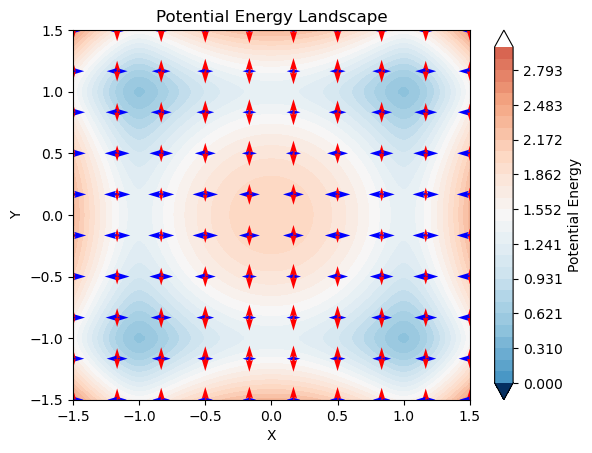

In [17]:
plot_potential_and_diffusion(quadruple_well_potential, anisotropic_diffusion_field, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=30)

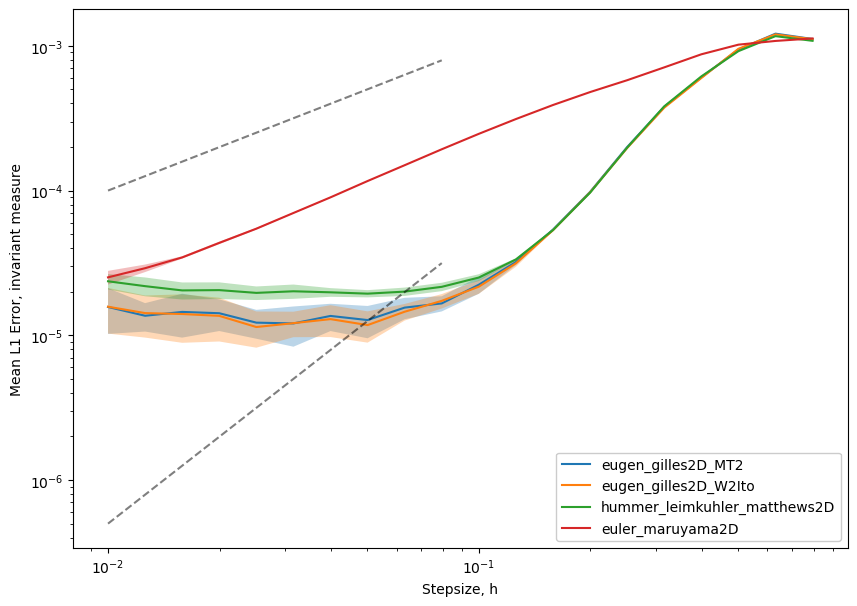

In [12]:
plot_experiments("qw_anisotropicII_500K", min_log10_stepsize=-2, base_dir="./simulation_results/", offset1=0.01, offset2=0.005, time_rescaling_factor=None, tr_trim=None, plot_dir="./plots")

#### 1.4 Anisotropic III (Moro-Cardin + Anisotropic II)

$$

D(x, y) = \frac{1}{1 + 5e^{- \frac{x^2 + y^2}{0.18}}} \begin{bmatrix}
1 - \sin(\theta)^2 / 2 & \cos(\theta) \sin(\theta) / 2 \\
\cos(\theta) \sin(\theta) / 2 & 1 - \cos(\theta)^2 / 2
\end{bmatrix}

$$

In [31]:
def anisotropic_morocardin_diffusion_field(x, y):
    theta = np.arctan2(y, x)
    factor = 1.0 + 5.0 * np.exp(- (x**2 + y**2) / (2 * 0.3**2))
    matrix = np.array([[1, 0],
                       [0, 1]]) - np.array([[x**2, x*y],
                       [x * y, y**2]])/(x**2 + y**2 + 1)
    return matrix / factor

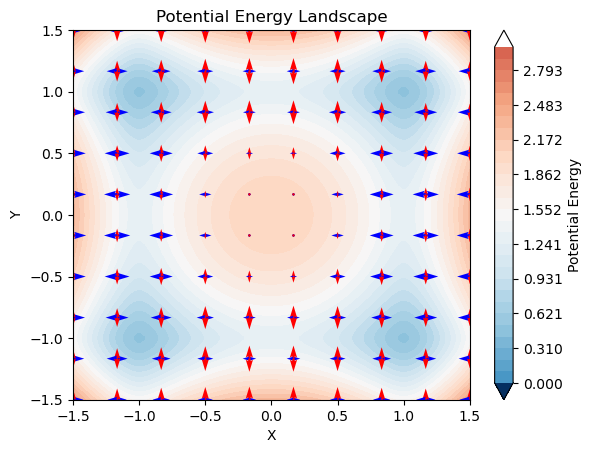

In [41]:
plot_potential_and_diffusion(quadruple_well_potential, anisotropic_morocardin_diffusion_field, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=30)

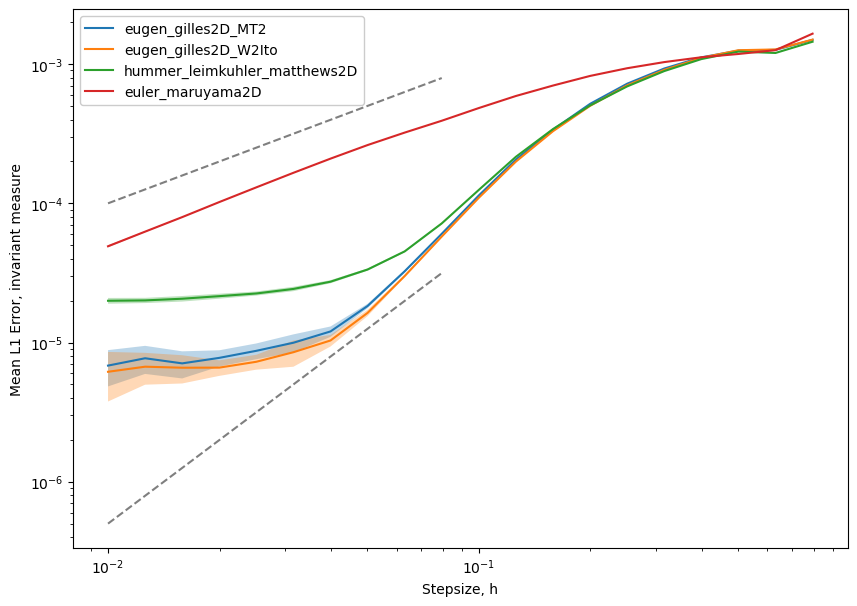

In [13]:
plot_experiments("qw_anisotropicIII_500K", min_log10_stepsize=-2, base_dir="./simulation_results/", offset1=0.01, offset2=0.005, time_rescaling_factor=None, tr_trim=None, plot_dir="./plots")

### Anisotropic III.5

$$

D(x, y) = \exp(0.5 *V(x,y) - 0.25 * x^2 - 0.25 * y^2) \begin{bmatrix}
1 - \sin(\theta)^2 / 2 & \cos(\theta) \sin(\theta) / 2 \\
\cos(\theta) \sin(\theta) / 2 & 1 - \cos(\theta)^2 / 2
\end{bmatrix}

$$

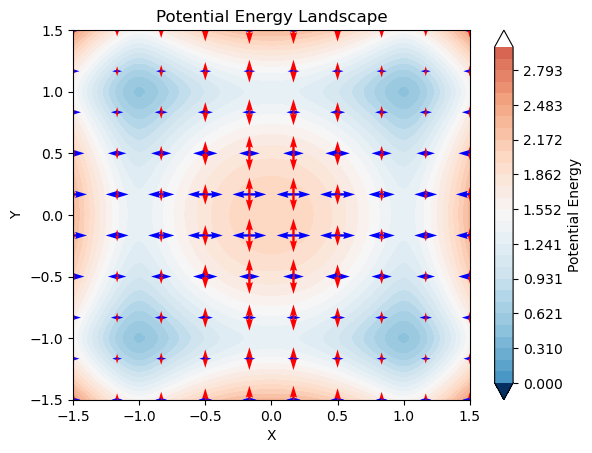

In [70]:
def anisotropic_homogenised_optimal_diffusion(x, y):
    theta = np.arctan2(y, x)
    factor = np.exp(0.5 * quadruple_well_potential(x,y) - 0.25 * x**2 - 0.25 * y**2)
    matrix = np.array([[1-np.sin(theta)**2 / 2, np.cos(theta) * np.sin(theta) / 2],
                       [np.cos(theta) * np.sin(theta)/2, 1 - np.cos(theta)**2 / 2]])
    return matrix * factor

plot_potential_and_diffusion(quadruple_well_potential, anisotropic_homogenised_optimal_diffusion, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=50)

### 2. Double-Well Entropic Channel 2D

#### 2.1 Potential

$$
V(x, y) = \frac{25y^2}{25x^2 + 1} + \frac{1}{6} \left( \sqrt{4(1-x^2 - y^2)^2 + 2(x^2 - 2)^2 + ((x+y)^2 -1)^2 + ((x-y)^2 -1)^2} - 2 \right)
$$

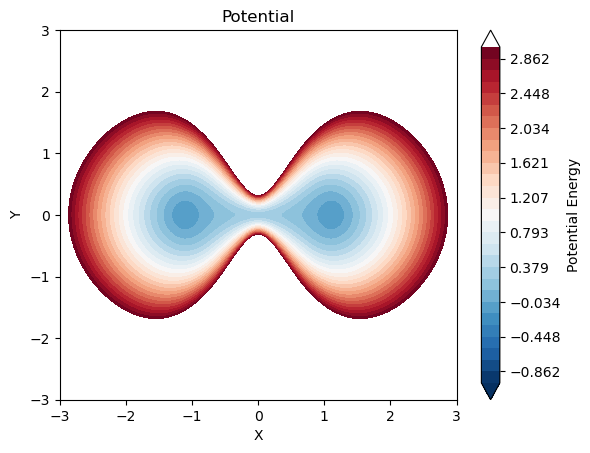

In [44]:
def potential_energy(x, y):
    term1 = (5*y)**2  / ((5*x)**2 + 1)
    term2 = (1/6) * (np.sqrt(4 * (1-x**2 - y**2)**2 + 2*(x**2 - 2)**2 + ((x+y)**2 -1)**2 +((x-y)**2 -1)**2) -2)
    return term1 + term2

plot_potential(potential_energy, min_grid=-3, max_grid=3, level_min=-1, level_max=3, num_levels=30)

#### 2.2 Isotropic (Moro-Cardin Diffusion)

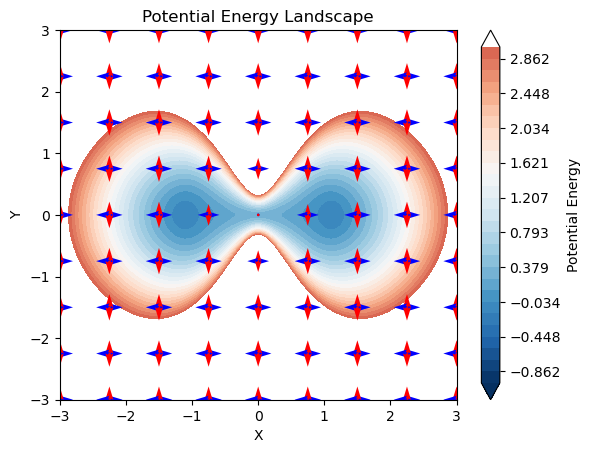

In [54]:
plot_potential_and_diffusion(potential_energy, isotropic_MoroCardin_diffusion_field, min_grid=-3, max_grid=3, level_min=-1, level_max=3, num_levels=30, diff_min=-3, diff_max=3, diff_scale=30, diff_levels=9)

#### 2.3 Anisotropic I

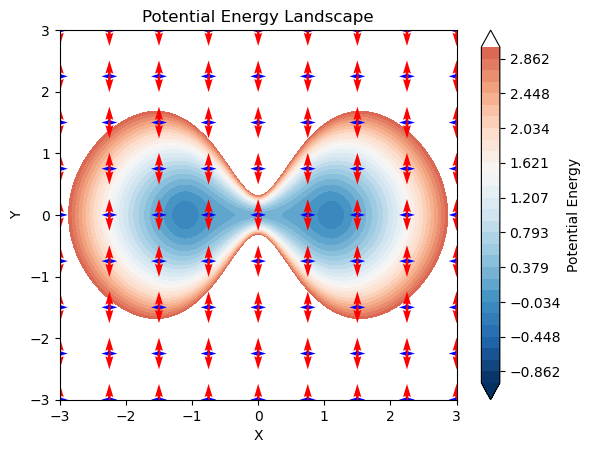

In [69]:
plot_potential_and_diffusion(potential_energy, basic_anisotropic_diffusion_field, min_grid=-3, max_grid=3, level_min=-1, level_max=3, num_levels=30, diff_min=-3, diff_max=3, diff_scale=50, diff_levels=9)

#### 2.4 Anisotropic II

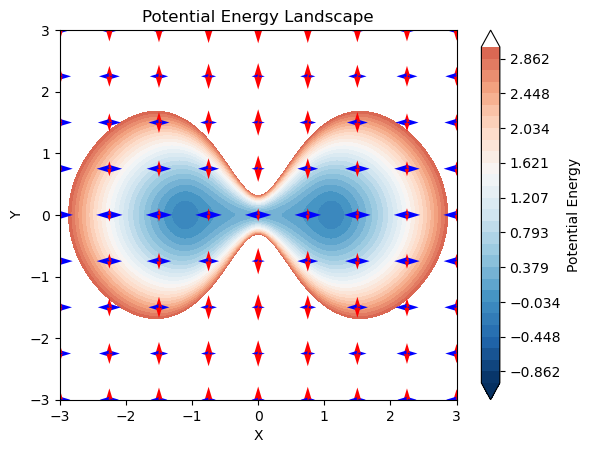

In [62]:
plot_potential_and_diffusion(potential_energy, anisotropic_diffusion_field, min_grid=-3, max_grid=3, level_min=-1, level_max=3, num_levels=30, diff_min=-3, diff_max=3, diff_scale=30, diff_levels=9)

#### 2.3 Anisotropic III

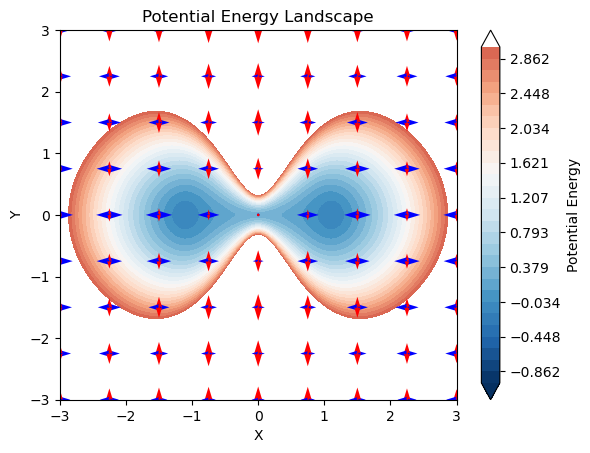

In [56]:
plot_potential_and_diffusion(potential_energy, anisotropic_morocardin_diffusion_field, min_grid=-3, max_grid=3, level_min=-1, level_max=3, num_levels=30, diff_min=-3, diff_max=3, diff_scale=30, diff_levels=9)

#### 2.3 Anisotropic IV (Barrier-Hopping Diffusion)

$$
D(x, y) = \begin{bmatrix}
\frac{\max(2 - V(x,y), 1)}{1 + \min(\lvert V_{xx}(x,y) \rvert, 5)} & 0 \\
0 & \frac{\max(2 - V(x,y), 1)}{1 + \min(\lvert V_{yy}(x,y) \rvert, 5)}
\end{bmatrix}
$$

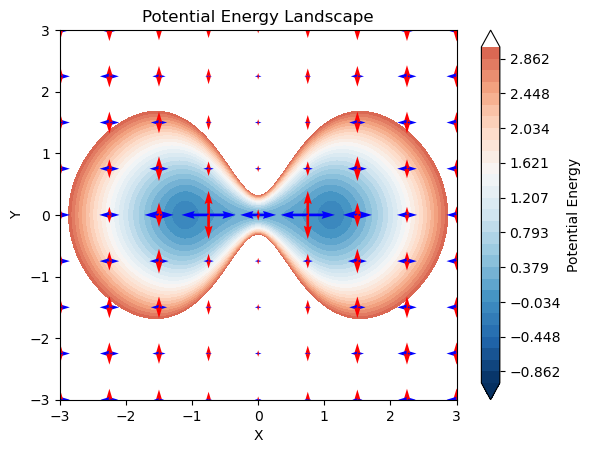

In [60]:
def second_partial_y_derivative(x, y):
    result = 10 / (1 + 25 * x**2) + (np.sqrt(2) * (20 * x**6 + 2 * x**4 * (-31 + 18 * y**2) + 5 * x**2 * (13 - 18 * y**2 + 9 * y**4) + 3 * (-7 + 21 * y**2 - 9 * y**4 + 3 * y**6))) / (3 * (7 + 4 * x**4 - 6 * y**2 + 3 * y**4 + 10 * x**2 * (-1 + y**2))**(3/2))
    return result

def second_partial_x_derivative(x, y):
    term1 = (250 * (-1 + 75 * x**2) * y**2) / (1 + 25 * x**2)**3
    term2 = (np.sqrt(2) * (16 * x**6 + 60 * x**4 * (-1 + y**2) + 12 * x**2 * (7 - 6 * y**2 + 3 * y**4) + 5 * (-7 + 13 * y**2 - 9 * y**4 + 3 * y**6))) / (3 * (7 + 4 * x**4 - 6 * y**2 + 3 * y**4 + 10 * x**2 * (-1 + y**2))**(3/2))
    
    result = term1 + term2
    return result

def first_partial_y_derivative(x, y):
    term1 = (10 * y) / (1 + 25 * x**2)
    term2 = (np.sqrt(2) * y * (-3 + 5 * x**2 + 3 * y**2)) / (3 * np.sqrt(7 + 4 * x**4 - 6 * y**2 + 3 * y**4 + 10 * x**2 * (-1 + y**2)))
    
    result = term1 + term2
    return result

def first_partial_x_derivative(x, y):
    term1 = -(250 * x * y**2) / (1 + 25 * x**2)**2
    term2 = (np.sqrt(2) * x * (-5 + 4 * x**2 + 5 * y**2)) / (3 * np.sqrt(7 + 4 * x**4 - 6 * y**2 + 3 * y**4 + 10 * x**2 * (-1 + y**2)))
    
    result = term1 + term2
    return result

def anisotropic_diffusion_field(x, y):
    matrix = np.array([[max(2 - potential_energy(x, y), 1)/(1+min(np.abs(second_partial_x_derivative(x,y)), 5)), 0],
                       [0, max(2 - potential_energy(x, y), 1)/(1+min(np.abs(second_partial_y_derivative(x,y)), 5))]])
    return matrix

plot_potential_and_diffusion(potential_energy, anisotropic_diffusion_field, min_grid=-3, max_grid=3, level_min=-1, level_max=3, num_levels=30, diff_min=-3, diff_max=3, diff_scale=20, diff_levels=9)

## 1.3 Single well potential

$$
V(x) = \sqrt{(x^2 + y^2)*(4/5)}
$$

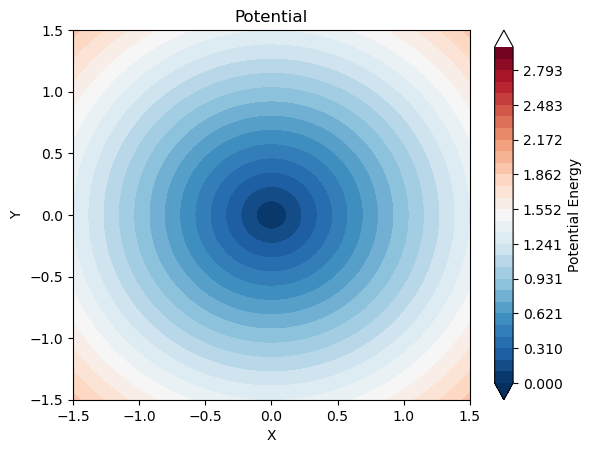

In [23]:
def single_well_potential(x, y):
    return np.sqrt((x**2 + y**2)*(4/5))

plot_potential(single_well_potential, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30)

### 1.3.1 Isotropic

$$
D(x, y) = \frac{1}{1 + 5e^{- \frac{x^2 + y^2}{0.18}}} \mathbf{1}_{2 \times 2}
$$

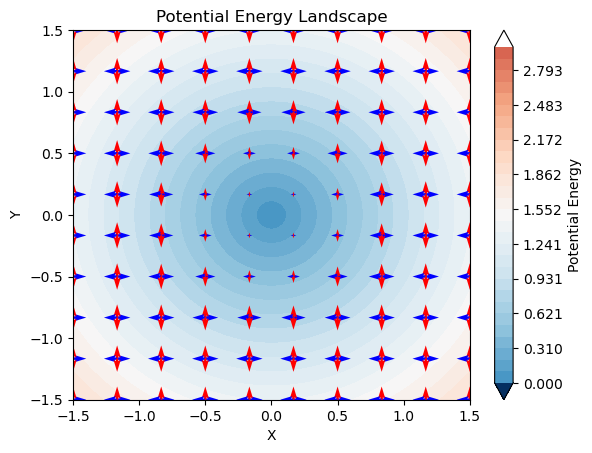

In [12]:
def isotropic_MoroCardin_diffusion_field(x, y):
    return 1/(1.0 + 5.0 * np.exp(- (x**2 + y**2) / (2 * 0.3**2))) * np.array([[1, 0], [0, 1]])

plot_potential_and_diffusion(single_well_potential, isotropic_MoroCardin_diffusion_field, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=30)

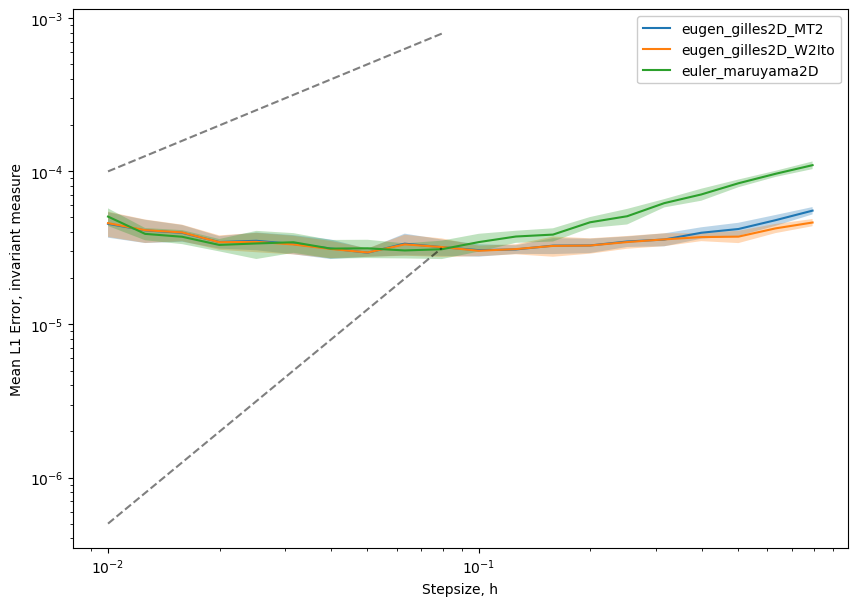

In [14]:
plot_experiments("sw_isotropic_50K", min_log10_stepsize=-2, base_dir="./simulation_results/", offset1=0.01, offset2=0.005, time_rescaling_factor=None, tr_trim=None, plot_dir="./plots")

### 1.3.2 Anisotropic I

$$
D(x, y) = \begin{bmatrix}
1 & 0 \\
0 & 2
\end{bmatrix}
$$

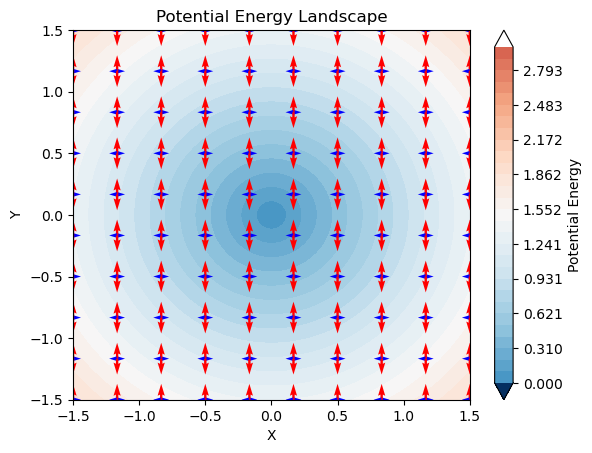

In [14]:
def basic_anisotropic_diffusion_field(x, y):
    return np.array([[1, 0], [0, 2]])

plot_potential_and_diffusion(single_well_potential, basic_anisotropic_diffusion_field, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=50)

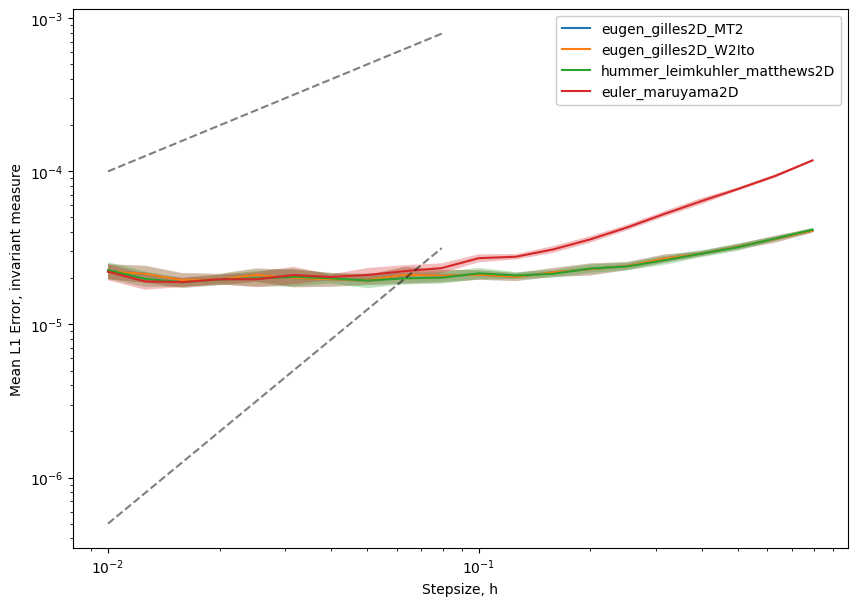

In [15]:
plot_experiments("sw_anisotropicI_50K", min_log10_stepsize=-2, base_dir="./simulation_results/", offset1=0.01, offset2=0.005, time_rescaling_factor=None, tr_trim=None, plot_dir="./plots")

### Anisotropic II

$$
D(r, \theta) = \begin{bmatrix}
1 - \sin(\theta)^2 / 2 & \cos(\theta) \sin(\theta) / 2 \\
\cos(\theta) \sin(\theta) / 2 & 1 - \cos(\theta)^2 / 2
\end{bmatrix}
$$

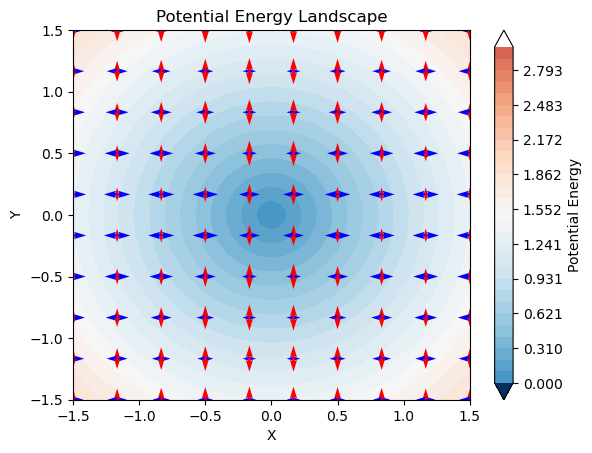

In [18]:
def anisotropic_diffusion_field(x, y):
    theta = np.arctan2(y, x)
    matrix = np.array([[1-np.sin(theta)**2 / 2, np.cos(theta) * np.sin(theta) / 2],
                       [np.cos(theta) * np.sin(theta)/2, 1 - np.cos(theta)**2 / 2]])
    return matrix

plot_potential_and_diffusion(single_well_potential, anisotropic_diffusion_field, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=30)

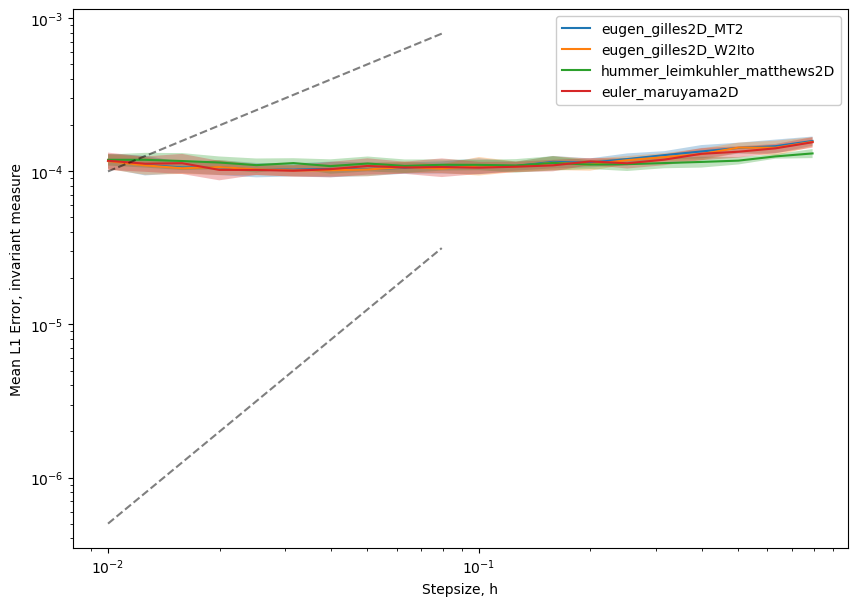

In [16]:
plot_experiments("sw_anisotropicII_5K", min_log10_stepsize=-2, base_dir="./simulation_results/", offset1=0.01, offset2=0.005, time_rescaling_factor=None, tr_trim=None, plot_dir="./plots")

### Anisotropic III

$$

D(x, y) = \frac{1}{1 + 5e^{- \frac{x^2 + y^2}{0.18}}} \begin{bmatrix}
1 - \sin(\theta)^2 / 2 & \cos(\theta) \sin(\theta) / 2 \\
\cos(\theta) \sin(\theta) / 2 & 1 - \cos(\theta)^2 / 2
\end{bmatrix}

$$

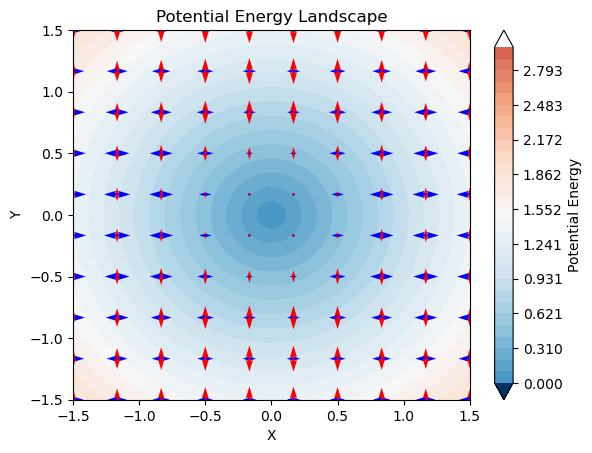

In [19]:
def anisotropic_morocardin_diffusion_field(x, y):
    theta = np.arctan2(y, x)
    factor = 1.0 + 5.0 * np.exp(- (x**2 + y**2) / (2 * 0.3**2))
    matrix = np.array([[1-np.sin(theta)**2 / 2, np.cos(theta) * np.sin(theta) / 2],
                       [np.cos(theta) * np.sin(theta)/2, 1 - np.cos(theta)**2 / 2]])
    return matrix / factor

plot_potential_and_diffusion(single_well_potential, anisotropic_morocardin_diffusion_field, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=30)

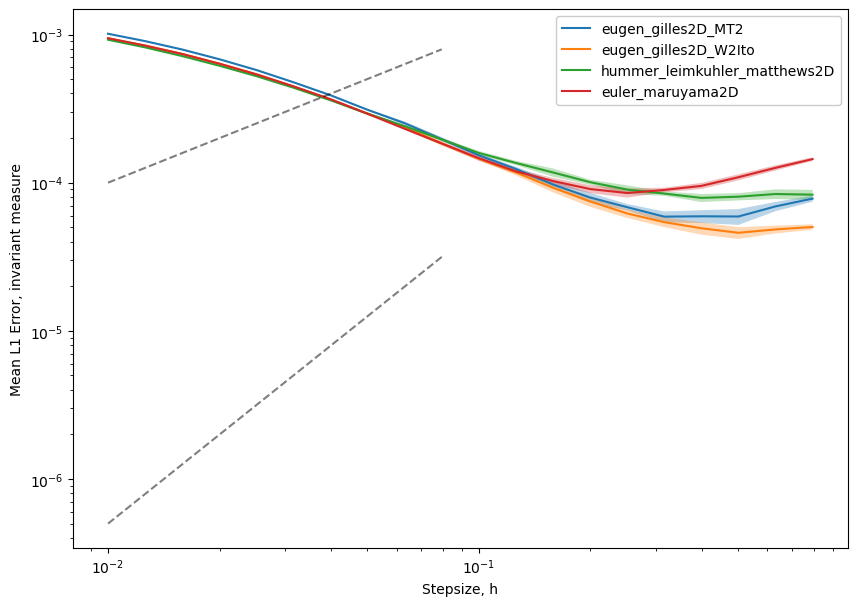

In [17]:
plot_experiments("sw_anisotropicIII_500K", min_log10_stepsize=-2, base_dir="./simulation_results/", offset1=0.01, offset2=0.005, time_rescaling_factor=None, tr_trim=None, plot_dir="./plots")

### Anisotropic III.5

$$

D(x, y) = \exp(-V(x,y)) \begin{bmatrix}
1 - \sin(\theta)^2 / 2 & \cos(\theta) \sin(\theta) / 2 \\
\cos(\theta) \sin(\theta) / 2 & 1 - \cos(\theta)^2 / 2
\end{bmatrix}

$$

In [30]:
def anisotropic_homogenised_optimal_diffusion(x, y):
    theta = np.arctan2(y, x)
    factor = np.exp(single_well_potential(x,y))
    matrix = np.array([[1-np.sin(theta)**2 / 2, np.cos(theta) * np.sin(theta) / 2],
                       [np.cos(theta) * np.sin(theta)/2, 1 - np.cos(theta)**2 / 2]])
    return matrix * factor

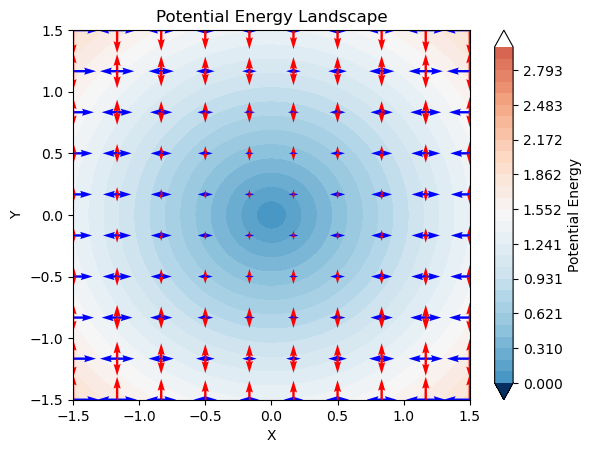

In [33]:
plot_potential_and_diffusion(single_well_potential, anisotropic_homogenised_optimal_diffusion, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=80)

### Anisotropic IV

$$
D(r, \theta) = \sin(3x) \frac{2e^y}{e^y +1}\begin{bmatrix}
1 - \sin(\theta)^2 / 2 & \cos(\theta) \sin(\theta) / 2 \\
\cos(\theta) \sin(\theta) / 2 & 1 - \cos(\theta)^2 / 2
\end{bmatrix}
$$

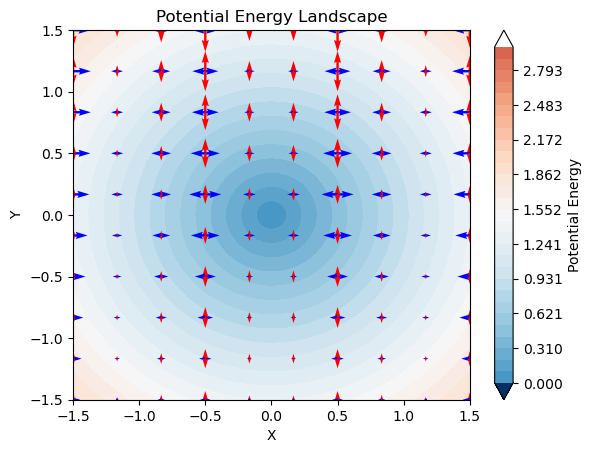

In [7]:
def anisotropic_diffusion_field(x, y):
    theta = np.arctan2(y, x)
    matrix = np.array([[1-np.sin(theta)**2 / 2, np.cos(theta) * np.sin(theta) / 2],
                       [np.cos(theta) * np.sin(theta)/2, 1 - np.cos(theta)**2 / 2]]) * np.sin(3 * x) * (np.exp(y) + 0.2)/(np.exp(y) + 1) * 2
    return matrix

plot_potential_and_diffusion(single_well_potential, anisotropic_diffusion_field, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=30)

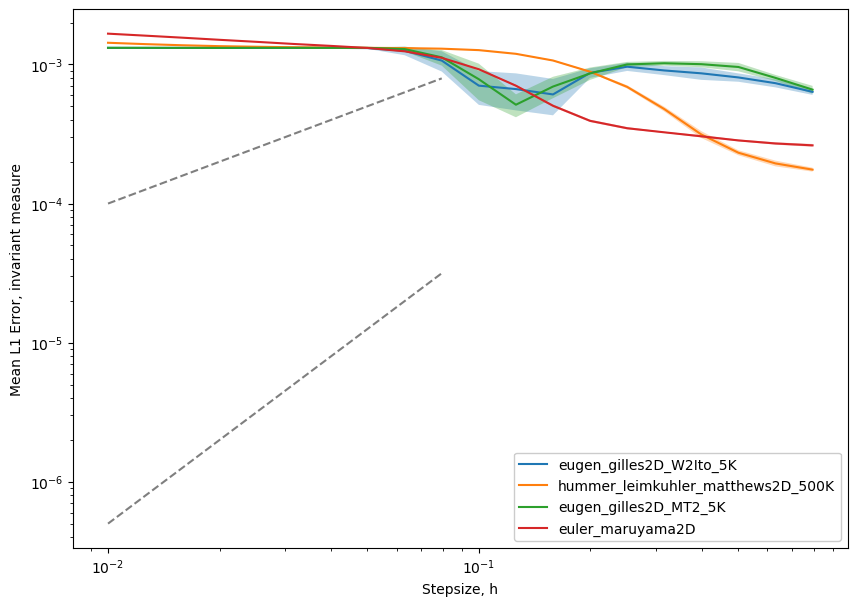

In [18]:
plot_experiments("sw_anisotropicIV_50K", min_log10_stepsize=-2, base_dir="./simulation_results/", offset1=0.01, offset2=0.005, time_rescaling_factor=None, tr_trim=None, plot_dir="./plots")

### Anisotropic V

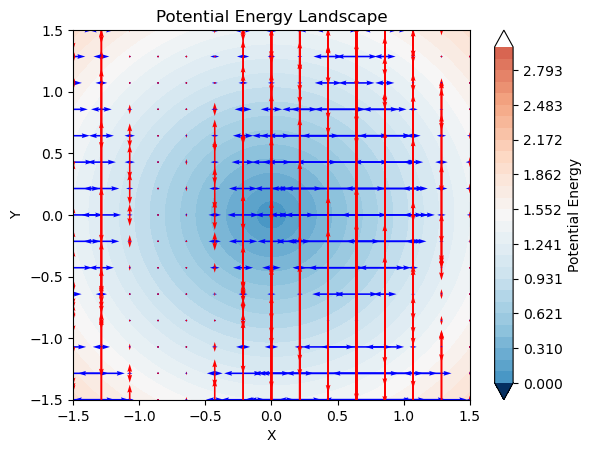

In [19]:
def function_1D(x, a, b):
    result = 0
    for i in range(len(a)):
        result += a[i] * np.cos(i * x + b[i]) / np.sqrt((i+1))
    return result


def random_1D_fourier_series_coefficients(num_terms):
    a = np.random.randn(num_terms)
    b = np.random.randn(num_terms)

    return a, b

def random_positive_semi_definite_matrix_field(terms):
    a1, b1 = random_1D_fourier_series_coefficients(terms) #lambda_1_x, 
    a2, b2 = random_1D_fourier_series_coefficients(terms) #lambda_1_y,
    a3, b3  = random_1D_fourier_series_coefficients(terms) #lambda_2_x, 
    a4, b4 = random_1D_fourier_series_coefficients(terms) #lambda_2_y, 
    a5, b5 = random_1D_fourier_series_coefficients(terms) #u1_x, 
    a6, b6 = random_1D_fourier_series_coefficients(terms) #u1_y, 
    a7, b7 = random_1D_fourier_series_coefficients(terms) #u2_x, 
    a8, b8 = random_1D_fourier_series_coefficients(terms) #u2_y, 

    def matrix_field(x, y):
        D = np.array([[function_1D(x, a1, b1)**2 * function_1D(y, a2, b2) ** 2 + 0.1, 0], [0, function_1D(x, a3, b3) **2 * function_1D(y, a4, b4) ** 2 + 0.1]])
        P = np.array([[function_1D(x, a5, b5) * function_1D(y, a6, b6), function_1D(x, a7, b7) * function_1D(y, a8, b8)], [function_1D(x, a7, b7) * function_1D(y, a8, b8), function_1D(x, a5, b5) * function_1D(y, a6, b6)]])
        return P @ D @ P.T
    
    return matrix_field, a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6, a7, b7, a8, b8

def construct_matrix_field(list_of_a, list_of_b):
    def matrix_field(x, y):
        D = np.array([[function_1D(x, list_of_a[0], list_of_b[0])**2 * function_1D(y, list_of_a[1], list_of_b[1]) ** 2 + 0.2, 0], [0, function_1D(x, list_of_a[2], list_of_b[2]) **2 * function_1D(y, list_of_a[3], list_of_b[3]) ** 2 + 0.2]])
        P = np.array([[function_1D(x, list_of_a[4], list_of_b[4]) * function_1D(y, list_of_a[5], list_of_b[5]) + 0.2, function_1D(x, list_of_a[6], list_of_b[6]) * function_1D(y, list_of_a[7], list_of_b[7]) + 0.2], [function_1D(x, list_of_a[6], list_of_b[6]) * function_1D(y, list_of_a[7], list_of_b[7]) + 0.2, function_1D(x, list_of_a[4], list_of_b[4]) * function_1D(y, list_of_a[5], list_of_b[5]) + 0.2]])
        return P @ D @ P.T
    
    return matrix_field

random_matrix_field, a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6, a7, b7, a8, b8 = random_positive_semi_definite_matrix_field(5)
plot_potential_and_diffusion(single_well_potential, random_matrix_field, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=30, diff_levels=15)

list_of_a = [a1, a2, a3, a4, a5, a6, a7, a8]
list_of_b = [b1, b2, b3, b4, b5, b6, b7, b8]


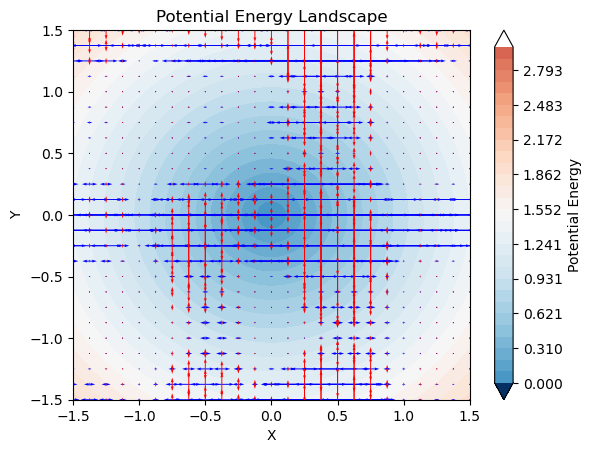

In [21]:
list_of_a = [[ 1.10609511, -1.54558424,  0.54125102, -0.39846411, -1.82174564], [-0.00367704, -0.57833659,  0.8950395 , -1.69792379,  0.88727313], [-0.37859394,  0.26414013, -0.97688349,  0.84549204, -1.61668411], [-1.33109584,  2.48349712, -1.46783594, -1.05530731,  0.04105189], [ 0.20287527, -1.15666989,  2.17669036,  1.06308684, -0.12260126], [ 0.24829756,  0.27780516,  1.02279586, -0.59432211,  0.19903113], [-1.00978779, -1.04440693, -0.16481296,  0.45701152, -0.73295171], [-0.09623664, -0.6489985 , -0.60125891, -0.17327419, -1.80877051]]
list_of_b = [[-0.9795475 ,  0.39279739, -0.742023  , -0.02982569,  1.23266377], [-0.96997948, -1.03639312,  0.44054334,  0.14259723,  0.73073318], [ 0.26579704,  0.86919929, -0.68803677,  1.55283354, -1.30792944], [-0.36751069,  1.49241352,  0.93835149,  0.84830419, -1.20974195], [-0.27629405,  0.1472921 ,  1.19804383,  1.34801694, -1.41093702], [0.08145364, 1.76403037, 1.22359871, 0.39626338, 0.72073047], [-0.43352454,  0.35754441, -0.67806083,  0.86632526, -0.00166055], [ 0.64026383, -0.65200475,  2.223142  ,  0.7834324 ,  0.03410119]]
matrix_field = construct_matrix_field(list_of_a, list_of_b)
plot_potential_and_diffusion(single_well_potential, matrix_field, min_grid=-1.5, max_grid=1.5, level_min=0, level_max=3, num_levels=30, diff_min=-1.5, diff_max=1.5, diff_scale=100, diff_levels=25)

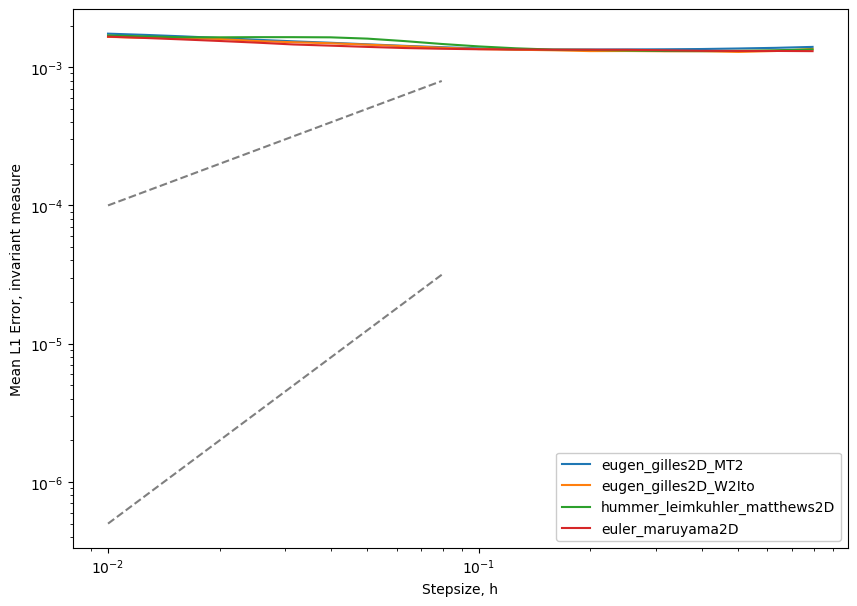

In [19]:
plot_experiments("sw_anisotropicV_500K", min_log10_stepsize=-2, base_dir="./simulation_results/", offset1=0.01, offset2=0.005, time_rescaling_factor=None, tr_trim=None, plot_dir="./plots")